In [46]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.optimize import minimize
from common.model_lr import *
from common.inference import nuts, rhat, hmc
import bayesiancoresets as bc
import pandas as pd

# The example given in Campbell & Broderick

In [68]:
# parameters
dataname = 'phishing'
algname = 'GIGA' # can be GIGA / FW / RND
ID = 1

In [69]:
# initialization
algdict = {'GIGA':bc.snnls.GIGA, 'FW':bc.snnls.FrankWolfe, 'RND':bc.snnls.UniformSampling}

np.random.seed(int(ID))

mcmc_steps = 5000 #total number of MH steps
mcmc_burn = 1000
projection_dim = 500 #random projection dimension
Ms = np.unique(np.logspace(0, 3, 10, dtype=int))
Ms = np.array([50])
print(Ms)

pbar = True #progress bar display flag
step_size_init = 0.001
n_leap = 15
target_a = 0.8
mcmc_alg = hmc #nuts

[50]


In [77]:
# Load data
datafile = 'data/' + dataname + '.npz'
data = np.load(datafile)
X = data['X']
Xt = data['Xt']
print(X)
#print(Xt)
print(X.shape, Xt.shape)
print(data['y'])
print(data['yt'])
print(data['y'].shape, data['yt'].shape)

[[-0.13552214 -0.21418322  0.13368857 ... -0.41769558 -0.12906334
   1.        ]
 [ 0.2366381  -0.028549   -0.05507373 ... -0.02676805 -0.4717898
   1.        ]
 [ 0.1945081  -0.0089337   0.01347461 ... -0.04076594 -0.52867629
   1.        ]
 ...
 [-0.02339004 -0.07812694  0.09948859 ...  0.03499793 -0.22752027
   1.        ]
 [-0.18276716  0.13937916  0.03936396 ...  0.02933968 -0.46084692
   1.        ]
 [ 0.05323274 -0.18775962 -0.12507893 ...  0.01763863 -0.3791133
   1.        ]]
(500, 11) (50, 11)
[ 1.  1.  1. -1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1.
  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.
 -1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.
  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1. -1.
  1. -1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1.
  1.  1. -1.  1. -1. -1.  1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.
 -1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1. 

In [74]:
# standardize the covariates; last col is intercept, so no stdization there
m = X[:, :-1].mean(axis=0)
V = np.cov(X[:, :-1], rowvar=False)+1e-12*np.eye(X.shape[1]-1)
X[:, :-1] = np.linalg.solve(np.linalg.cholesky(V), (X[:, :-1] - m).T).T
Xt[:, :-1] = np.linalg.solve(np.linalg.cholesky(V), (Xt[:, :-1] - m).T).T
Z = data['y'][:, np.newaxis]*X
Zt = data['yt'][:, np.newaxis]*Xt
D = Z.shape[1]
print(Z)
#print(Zt)
print(Z.shape, Zt.shape)

[[-1.47800908 -1.13181029  0.65818148 ... -2.15479175  1.17964757
   1.        ]
 [ 1.88004196  0.44981986 -0.71480223 ... -0.15383692 -0.63730917
   1.        ]
 [ 1.49989739  0.62661681 -0.11714302 ... -0.32545665 -0.86874739
   1.        ]
 ...
 [-0.46622631  0.04648211  0.48451305 ...  0.39719631  0.43026365
   1.        ]
 [ 1.90430707 -1.97036593  0.05906681 ... -0.13690065  0.6023032
  -1.        ]
 [-0.22515114  0.9227998   1.53336055 ... -0.14772742  0.15247848
  -1.        ]]
(500, 11) (50, 11)


In [44]:
print(Z)
#print(Zt)
print(Z.shape, Zt.shape)
#print(X)

[[ 0.96234722  0.88680166  1.        ]
 [ 1.20578801  0.89919662 -1.        ]
 [ 0.48343226  0.39607497 -1.        ]
 ...
 [ 2.21985569 -0.95121555  1.        ]
 [ 0.60657125  0.4736645   1.        ]
 [ 0.03313489  0.85894188  1.        ]]
(500, 3) (50, 3)


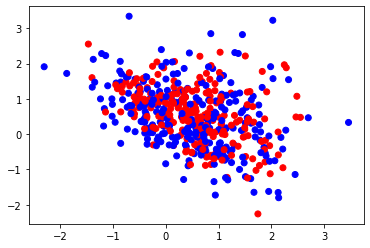

In [43]:
colors = ['red' if l == 1 else 'blue' for l in Z[:,2]]
plt.scatter(Z[:,0], Z[:,1], color=colors)

In [7]:
print('Computing Laplace approximation for '+dataname)
res = minimize(lambda mu : -log_joint(Z, mu, np.ones(Z.shape[0])), Z.mean(axis=0)[:D], jac=lambda mu : -grad_log_joint(Z, mu, np.ones(Z.shape[0])))
mu = res.x
cov = -np.linalg.inv(hess_log_joint(Z, mu))
print('mu:\n', mu)
print('cov:\n', cov)

Computing Laplace approximation for synth_lr
mu:
 [ 3.03314095  3.08039501 -0.60320514]
cov:
 [[ 0.07988719  0.0591189  -0.01292515]
 [ 0.0591189   0.0806745  -0.01306789]
 [-0.01292515 -0.01306789  0.0246806 ]]


In [8]:
#generate a sampler based on the laplace approx 
sampler = lambda sz, w, ids : np.atleast_2d(np.random.multivariate_normal(mu, cov, sz))

In [9]:
#create the log-likelihood eval function
def loglike(prms):
    return np.hstack([log_likelihood(Z, prms[i,:])[:,np.newaxis] for i in range(prms.shape[0])])

In [10]:
tsf = bc.BayesianTangentSpaceFactory(loglike, sampler, projection_dim)

In [11]:
print('Running MCMC on the full dataset '+ dataname)
logpZ = lambda th : log_joint(Z, th, np.ones(Z.shape[0]))
glogpZ = lambda th : grad_log_joint(Z, th, np.ones(Z.shape[0]))
mcmc_param_init = np.random.multivariate_normal(mu, cov)
full_samples = mcmc_alg(logp = logpZ, gradlogp = glogpZ, x0 = mcmc_param_init, sample_steps=mcmc_steps, 
                        burn_steps=mcmc_burn, adapt_steps=mcmc_burn, n_leapfrogs = n_leap, 
                        scale=np.ones(mu.shape[0]), progress_bar=pbar, step_size=step_size_init, target_accept=target_a) 

Running MCMC on the full dataset synth_lr
Progress: [##############################] 6000 of 6000 steps
Step size
0.17572861099502432
Accept rate
0.922


In [12]:
print(full_samples)

[[ 3.12631649  3.02885538 -0.76491991]
 [ 2.90437653  2.95423639 -0.71410029]
 [ 3.05249668  2.90891897 -0.68827172]
 ...
 [ 3.30215662  3.55432665 -0.59411475]
 [ 3.2120773   3.27657051 -0.5660678 ]
 [ 3.10926804  3.29486176 -0.5851078 ]]


In [13]:
csizes = np.zeros(Ms.shape[0])
Fs = np.zeros(Ms.shape[0])

In [14]:
print('Running coreset construction / MCMC for ' + dataname + ' ' + algname + ' ' + str(ID))
alg = bc.HilbertCoreset(tsf, snnls = algdict[algname])
for m in range(Ms.shape[0]):
    print('M = ' + str(Ms[m]) + ': coreset construction, '+ algname + ' ' + dataname + ' ' + str(ID))
    #this runs alg up to a level of M; on the next iteration, it will continue from where it left off
    alg.build(Ms[m] if m == 0 else Ms[m] - Ms[m-1], Ms[m])
    wts, idcs = alg.weights()

    logpZ = lambda th : log_joint(Z[idcs, :], th, wts)
    glogpZ = lambda th : grad_log_joint(Z[idcs, :], th, wts)
    mcmc_param_init = np.random.multivariate_normal(mu, cov)
    print('M = ' + str(Ms[m]) + ': MCMC')
    th_samples = mcmc_alg(logp=logpZ, gradlogp=glogpZ, x0 = mcmc_param_init, sample_steps=mcmc_steps, 
                          burn_steps=mcmc_burn, adapt_steps=mcmc_burn, n_leapfrogs= n_leap, 
                          scale=np.ones(mu.shape[0]), progress_bar=pbar, step_size=step_size_init, target_accept=target_a)  

    print('M = ' + str(Ms[m]) + ': coreset sizes =', wts.shape[0])
    csizes[m] = wts.shape[0]
    print('M = ' + str(Ms[m]) + ': F norms')
    gcs = np.array([ grad_log_joint(Z[idcs, :], full_samples[i, :], wts) for i in range(full_samples.shape[0]) ])
    gfs = np.array([ grad_log_joint(Z, full_samples[i, :], np.ones(Z.shape[0])) for i in range(full_samples.shape[0]) ])
    temp_Fs = (((gcs - gfs)**2).sum(axis=1)).mean()
    Fs[m] = temp_Fs
    print('Fs({}) = {}'.format(Ms[m], temp_Fs))
    print('='*60)

Running coreset construction / MCMC for synth_lr GIGA 1
M = 50: coreset construction, GIGA synth_lr 1
M = 50: MCMC
Progress: [##############################] 6000 of 6000 steps
Step size
0.20372836510974296
Accept rate
0.8538
M = 50: coreset sizes = 22
M = 50: F norms
Fs(50) = 24.736687253791093


In [117]:
print(th_samples)

[[ 3.31662287  3.57236476 -0.03994825]
 [ 3.31662287  3.57236476 -0.03994825]
 [ 3.22998614  2.88721048 -0.47378742]
 ...
 [ 2.94183265  2.71150762 -0.49144774]
 [ 2.82223414  3.43517252 -1.08910194]
 [ 3.81115418  3.26655967 -0.18337171]]


In [91]:
print(csizes)
print(Fs)

[9.]
[46.88617244]


In [90]:
print(wts)
print(idcs)
print(Z[idcs, :])

[3.16579599e+00 1.15564239e+00 9.00686352e-01 1.09535352e+01
 4.55513867e+00 1.52422859e+01 5.21211165e+03 4.14030491e+02
 3.81306881e+00]
[ 35  36 106 301 302 367 439 452 480]
[[ 2.13888938 -1.80207523 -1.        ]
 [-0.0027867  -0.83894109 -1.        ]
 [-0.23922273 -0.30475859  1.        ]
 [-1.37663449  2.1221153  -1.        ]
 [ 2.1290987  -1.65283134 -1.        ]
 [-1.46994997  2.55534171  1.        ]
 [ 1.02140319  1.57255307 -1.        ]
 [ 0.93006155  1.23382382  1.        ]
 [ 1.97796962 -1.12232974  1.        ]]


In [15]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [18]:
x_train = Z[:,:2]
y_train = Z[:,2]
print(x_train.shape)
print(y_train.shape)
logisticRegr.fit(x_train, y_train)

(500, 2)
(500,)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
# Use score method to get accuracy of model
x_test = Zt[:,:2]
y_test = Zt[:,2]
print(x_test.shape)
print(y_test.shape)
score = logisticRegr.score(x_test, y_test)
print(score)

(50, 2)
(50,)
0.5


# Try on heart disease data

## First, without coresets

In [90]:
# Load data
dataname = 'heart'
datafile = 'data/' + dataname + '.csv'
df = pd.read_csv(datafile)
msk = np.random.rand(len(df)) < 0.8
train = df[msk].to_numpy()
test = df[~msk].to_numpy()
print(train.shape)
print(test.shape)
x_train = train[:,:-1]
x_test = test[:,:-1]
y_train = train[:,-1]
y_test = test[:,-1]

(240, 14)
(63, 14)


In [91]:
# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

In [92]:
logisticRegr.fit(x_train, y_train)

/Users/teague/ResearchWorkspace/Harrow_Algorithm_2/coresetEnv/lib/python3.7/site-packages/scikit_learn-0.22.2.post1-py3.7-macosx-10.15-x86_64.egg/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
score = logisticRegr.score(x_test, y_test)
print(score)

0.7301587301587301


## Then, with coresets

In [166]:
# parameters
dataname = 'heart'
algname = 'GIGA' # can be GIGA / FW / RND
ID = 1
M = 100

In [171]:
# Load data
datafile = 'data/' + dataname + '.csv'
df = pd.read_csv(datafile)
msk = np.random.rand(len(df)) < 0.8
train = df[msk].to_numpy()
test = df[~msk].to_numpy()
print(train.shape)
print(test.shape)
x_train = np.hstack((train[:,:-1], np.ones((train.shape[0],1))))
x_test = np.hstack((test[:,:-1], np.ones((test.shape[0],1))))
y_train = train[:,-1]
y_train[y_train == 0] = -1
y_test = test[:,-1]
y_test[y_test == 0] = -1
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(235, 14)
(68, 14)
(235, 14) (68, 14)
(235,) (68,)


In [172]:
# standardize the covariates; last col is intercept, so no stdization there
m = x_train[:, :-1].mean(axis=0)
V = np.cov(x_train[:, :-1], rowvar=False)+1e-12*np.eye(x_train.shape[1]-1)
x_train[:, :-1] = np.linalg.solve(np.linalg.cholesky(V), (x_train[:, :-1] - m).T).T
x_test[:, :-1] = np.linalg.solve(np.linalg.cholesky(V), (x_test[:, :-1] - m).T).T
Z = y_train[:, np.newaxis]*x_train
Zt = y_test[:, np.newaxis]*x_test
D = Z.shape[1]
print(Z)
#print(Zt)
print(Z.shape, Zt.shape)

[[ 0.90672862  0.78253491  1.95902758 ... -1.05891057 -2.25561583
   1.        ]
 [-2.002994    0.45594314  0.94556687 ... -0.18496145 -0.62234711
   1.        ]
 [ 0.12334176  0.69460635  0.03366061 ... -0.81340829 -0.4678544
   1.        ]
 ...
 [ 1.10769473 -0.55643292 -1.9184058  ...  0.15587639 -1.42596735
  -1.        ]
 [-1.46629066 -0.84534101  0.894043   ... -0.0079283  -0.71929766
  -1.        ]
 [-0.23525417  1.45471265  0.02437164 ... -0.66454723  0.07676595
  -1.        ]]
(235, 14) (68, 14)


In [173]:
logisticRegr.fit(Z[:,:-1], Z[:,-1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [174]:
score = logisticRegr.score(Zt[:,:-1], Zt[:,-1])
print(score)

0.6176470588235294


In [175]:
print('Computing Laplace approximation for '+dataname)
res = minimize(lambda mu : -log_joint(Z, mu, np.ones(Z.shape[0])), Z.mean(axis=0)[:D], jac=lambda mu : -grad_log_joint(Z, mu, np.ones(Z.shape[0])))
mu = res.x
cov = -np.linalg.inv(hess_log_joint(Z, mu))
print('mu:\n', mu)
#print('cov:\n', cov)

Computing Laplace approximation for heart
mu:
 [-0.79430344 -0.9327074   1.31370851 -0.53750772 -0.25410191 -0.13200417
  0.2391203   0.82647108 -0.3065421  -0.75497622  0.1295255  -0.67788112
 -0.325165    0.01172156]


In [176]:
# random projection dimension
projection_dim = 500

#generate a sampler based on the laplace approx 
sampler = lambda sz, w, ids : np.atleast_2d(np.random.multivariate_normal(mu, cov, sz))

#create the log-likelihood eval function
def loglike(prms):
    return np.hstack([log_likelihood(Z, prms[i,:])[:,np.newaxis] for i in range(prms.shape[0])])

tsf = bc.BayesianTangentSpaceFactory(loglike, sampler, projection_dim)

In [177]:
print('M = ' + str(M) + ': coreset construction, '+ algname + ' ' + dataname + ' ' + str(ID))
alg = bc.HilbertCoreset(tsf, snnls = algdict[algname])
#this runs alg up to a level of M; on the next iteration, it will continue from where it left off
alg.build(M, M)
wts, idcs = alg.weights()
print(wts)
print(idcs)

M = 100: coreset construction, GIGA heart 1
[  1.85357744   0.81610984   0.46721312   1.02431858   0.8149909
   0.50446016  19.18940844   0.61390422   1.25341384   1.94717978
   1.46440532   1.64729416   0.84679952   1.1624973    1.97957223
   0.6979208    0.66066933   1.909903     1.26211543   0.47543797
   0.60494476   0.23499389   3.92414953   3.82399324   4.44541597
   0.50678792   0.88008827   1.65679804   1.81679493   0.51317197
   1.95379537   1.0529161    1.17575486   0.21613273   2.0546286
   1.3847124    1.10752304   3.0605072   17.28412157   0.32374303
 175.31045487   0.41328579  19.79062851   0.48737314   0.70262015
   1.05603302   4.31359783   0.79376747   1.37889552   0.27804026
   0.83095192   1.18624068   1.18732669  25.35839699   1.3749921
   1.23748746   0.48674076   0.45200049   1.68238683   0.7783572
   1.75609566   0.87003822   0.95932489   0.62148232]
[  0   3   4   5   6   9  10  12  13  14  17  21  23  38  47  51  60  61
  62  65  67  69  70  74  84  87 103 104 

In [178]:
logisticRegr.fit(Z[idcs,:-1], Z[idcs,-1], sample_weight=wts)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [179]:
score = logisticRegr.score(Zt[:,:-1], Zt[:,-1])
print(score)

0.39705882352941174


## Loop through different coreset sizes (M)

In [181]:
for M in [10,20,40,80,160,200]:
    print('M = ' + str(M) + ': coreset construction, '+ algname + ' ' + dataname + ' ' + str(ID))
    alg = bc.HilbertCoreset(tsf, snnls = algdict[algname])
    #this runs alg up to a level of M; on the next iteration, it will continue from where it left off
    alg.build(M, M)
    wts, idcs = alg.weights()
    logisticRegr.fit(Z[idcs,:-1], Z[idcs,-1], sample_weight=wts)
    score = logisticRegr.score(Zt[:,:-1], Zt[:,-1])
    print(score)

M = 10: coreset construction, GIGA heart 1
0.5441176470588235
M = 20: coreset construction, GIGA heart 1
0.4411764705882353
M = 40: coreset construction, GIGA heart 1
0.4852941176470588
M = 80: coreset construction, GIGA heart 1
0.47058823529411764
M = 160: coreset construction, GIGA heart 1
0.5441176470588235
M = 200: coreset construction, GIGA heart 1
0.4411764705882353
